In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import cv2
import sys
import math
import pickle as pk
import random
from pathlib import Path
PIPELINE_ROOT = Path('./').resolve().parent.parent.parent
sys.path.append(PIPELINE_ROOT.as_posix())
print(PIPELINE_ROOT)

from src.library.utilities.utilities_process import read_image, write_image

/home/eddyod/programming/pipeline


In [2]:
def show_image(img, increaser=1, _title="", fsize=[15,15]):
    plt.figure(figsize=[15,15])
    plt.imshow(img * increaser, cmap="gray")
    plt.title(_title,fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.show()

def collect_positives(uimg, startr, startc, tile_width, tile_height):
    img=np.copy(uimg)
    positives=[]
    radius = 80
    a=int(radius/2)
    color = (65000)
    min_row,min_col = startr, startc
    for index,r in df.iterrows():
        col = int(round(r['x'])-min_col)
        row = int(round(r['y'])-min_row)
        if (col<0) or (col>tile_width) or (row<0) or (row>tile_height):
            continue
        img=cv2.circle(img, (int(col), int(row)), radius, color, 20)
        I=uimg[row-a:row+a,col-a:col+a]
        if I.shape==(radius,radius):
            positives.append((col,row,I))

    return img,positives

In [3]:
animal = 'DK54'
section = 173
channel = 3
prep_path = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'

In [4]:
tif = str(section).zfill(3) + ".tif"
filepath = os.path.join(prep_path, f'C{channel}/full_aligned', tif)
full_img = read_image(filepath)
full_img.shape

(38000, 60000)

In [ ]:
filepath = os.path.join(prep_path, f'C{channel}/full_aligned', tif)
startr = 10000
endr = 17000
startc = 52500
endc = 60000
img = full_img[startr:endr, startc:endc]
print(img.shape)
write_image(filepath, img)


In [5]:
dfpath = os.path.join(prep_path, 'cell_labels', 'all_predictions.csv')
df = pd.read_csv(dfpath)
df = df.sort_values(['section', 'x', 'y'])

In [6]:
df = df.loc[df['section'] == section]
print(df.head(3))
print(df.tail(3))

         x        y  section
0  35873.0  15405.0      173
1  35948.0  15810.0      173
2  36092.0  15470.0      173
          x        y  section
14  39213.0  21920.0      173
9   40302.0  18859.0      173
15  40334.0  19244.0      173


In [7]:
count = len(df.index)
print(count)

16


In [8]:
startc = int(round(min(df['x']), -3))
startr = int(round(min(df['y']), -3))
endc = math.ceil(max(df['x']))
endr = math.ceil(max(df['y']))
# manually set to ROI
#startr = 0
#endr = full_img.shape[0]
#startc = 0
#endc = full_img.shape[1]
print(startr, endr, startc, endc)

15000 24045 36000 40334


In [9]:
tile_width = endc - startc
tile_height = endr - startr
img = full_img[startr:endr, startc:endc]
print(f'{startr}:{endr}, {startc}:{endc}')
print(img.shape)
#img.shape # (6800, 30000)

15000:24045, 36000:40334
(9045, 4334)


In [10]:
annotated_img, positives = collect_positives(img, startr, startc, tile_width, tile_height)
print(len(positives))

11


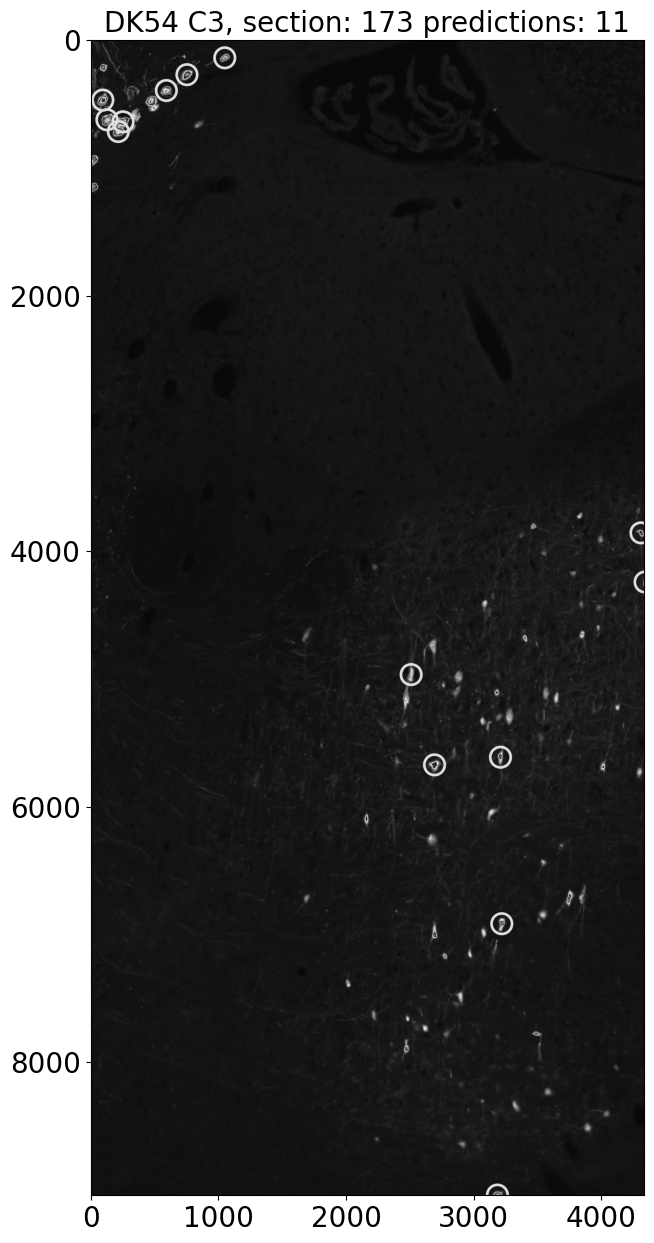

In [11]:
#vimg=annotated_img[in_row_min:in_row_max, in_col_min: in_col_max]
increaser = 15
show_image(annotated_img, increaser=increaser,_title=f'{animal} C{channel}, section: {section} predictions: {len(positives)}')

In [12]:
if len(positives) > 100:
    positives = b = random.sample(positives, 100)
print(len(positives))

11


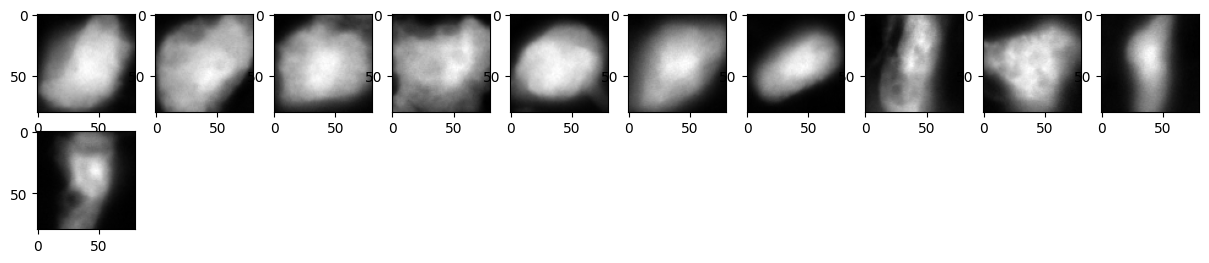

In [13]:
plt.figure(figsize=[15,15])
end = min(100, len(positives))
for i in range(len(positives[0:end])):
    plt.subplot(10,10,i+1)
    plt.imshow(positives[i][2], cmap="gray")
plt.show()

S.shape (11, 80, 80)
Mean.shape (80, 80)


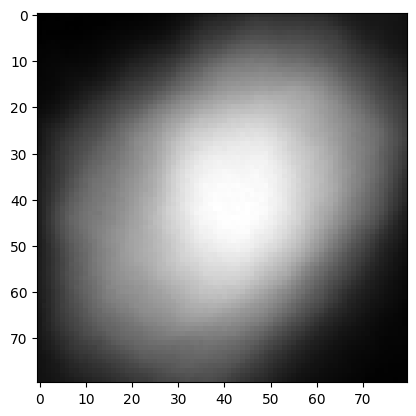

before: mean=3282.39 std=1918.28
after: mean=-0.00 std= 1.00
-rw-r--r-- 1 eddyod eddyod 51362 Feb 20 13:37 mean.pkl


In [14]:
S=np.stack([I for (x,y,I)in positives])
print('S.shape', S.shape)

Mean=np.mean(S,axis=0)
print('Mean.shape', Mean.shape)

plt.imshow(Mean, cmap="gray")
plt.show()

_mean=np.mean(Mean.flatten())
_std=np.std(Mean.flatten())
print('before: mean=%5.2f std=%5.2f'%(_mean,_std))

Mean = (Mean-_mean)/_std

_mean=np.mean(Mean.flatten())
_std=np.std(Mean.flatten())
print('after: mean=%5.2f std=%5.2f'%(_mean,_std))

with open('mean.pkl','wb') as pkl_file:
    pk.dump({'Mean':Mean},pkl_file)

!ls -l *.pkl

In [15]:
S8 = im0 = (S/256).astype(np.uint8)

S80 = S8[0, ...]
contours, _ = cv2.findContours(S80, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [16]:
cnt = contours[0]
M = cv2.moments(cnt)
Hm = cv2.HuMoments(M)
cv2.drawContours(S80, [cnt], -1, (0,255,255), 3)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

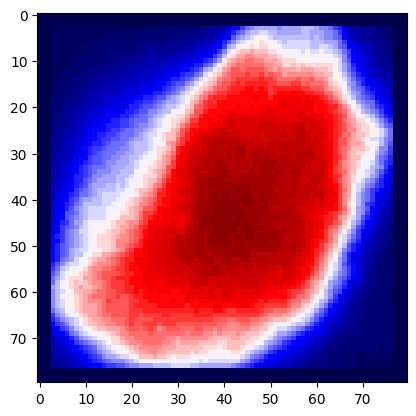

In [17]:
plt.imshow(S80, cmap="seismic")
plt.show()